# 1. Setup

In [1]:
#Agregamos una capa convolucional model1.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
#maxpooling2d
#Le cambiamos la salida a 64
#Obtuvimos un macro avg recall de 0.82
#Early stopping best epoch 23 with loss 0.5063

#dropout

## 1.1 Imports

In [2]:
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import bees_utils_macro as utils
import datetime

## 1.2 Set random seeds

In [3]:
np.random.seed(117)
tf.random.set_seed(117)

## 1.3 Global variables

In [4]:
img_width = 100
img_height = 100
img_channels = 3

# 2. Carga de datos

In [5]:
bees, bees_test_for_evaluation = utils.read_data()

In [6]:
bees.head()

,id,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,0,2018-08-06 14:48:00,020_011.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
1,1,2018-08-21 09:00:00,032_507.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
2,2,2018-08-21 09:00:00,032_612.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
3,3,2018-08-17 17:50:00,030_773.png,"Alvin, TX, USA",77511,Italian honey bee,ant problems,False,worker
4,4,2018-08-06 13:19:00,015_1052.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [7]:
bees_test_for_evaluation.head()

,id,datetime,file,location,zip code,pollen_carrying,caste
0,0,2018-08-28 16:07:00,042_012.png,"Alvin, TX, USA",77511,False,worker
1,1,2018-08-10 13:54:00,022_114.png,"Saratoga, CA, USA",95070,False,worker
2,2,2018-08-18 12:30:00,038_384.png,"Athens, Georgia, USA",30607,False,worker
3,3,2018-08-17 17:50:00,030_740.png,"Alvin, TX, USA",77511,False,worker
4,4,2018-07-07 12:56:00,005_310.png,"Saratoga, CA, USA",95070,False,worker


# 3. Análisis exploratorio de datos

## 3.1 Análisis descriptivo: Distribuciones, Scatterplots, Barplots...

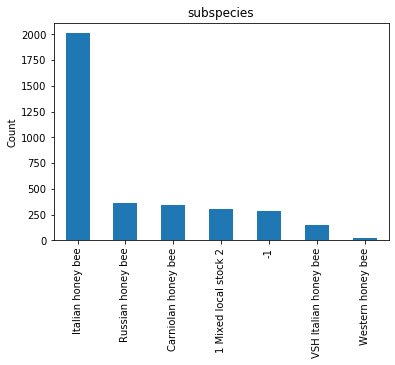

In [8]:
utils.value_counts(bees, 'subspecies')

## 3.2 Ver imágenes

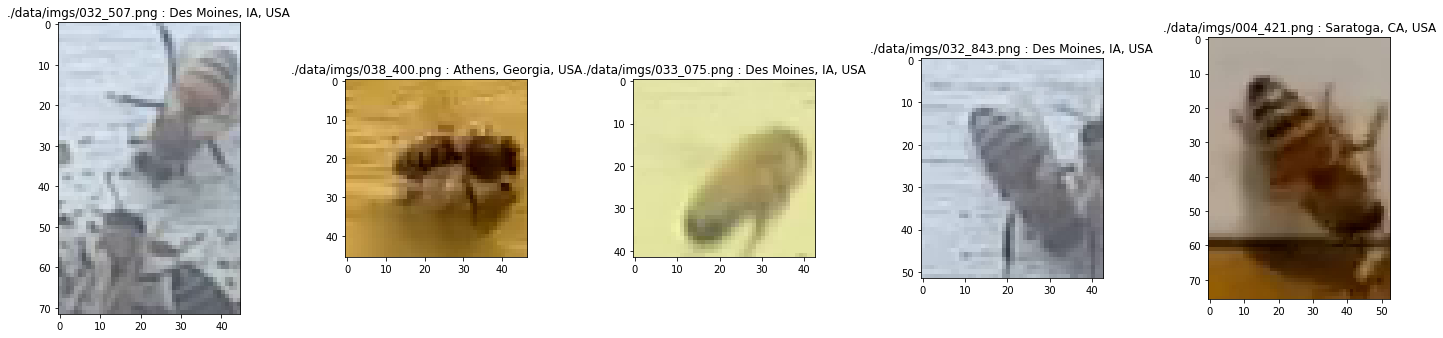

In [9]:
utils.plot_images(bees, 'location', [1, 25, 7, 100, 254])

# 4. Clasificación

## 4.1. Data preprocessing
### 4.1.1 Particionamiento

In [10]:
train_bees, val_bees, test_bees = utils.split(bees)


### 4.1.2 Carga de imágenes

In [11]:
# esta función ya uniformiza todas las imágenes en 100x100
train_X, val_X, test_X, train_y, val_y, test_y = utils.load_images_and_target(train_bees, 
                                                                              val_bees, 
                                                                              test_bees,
                                                                              'subspecies',
                                                                              img_width, 
                                                                              img_height,
                                                                              img_channels)

In [12]:
train_bees['subspecies']

225       Italian honey bee
2453      Italian honey bee
3009      Italian honey bee
3270    Carniolan honey bee
2622      Italian honey bee
               ...         
1275                     -1
1439      Italian honey bee
1175      Italian honey bee
2765      Italian honey bee
189     Carniolan honey bee
Name: subspecies, Length: 2338, dtype: category
Categories (7, object): [-1, 1 Mixed local stock 2, Carniolan honey bee, Italian honey bee, Russian honey bee, VSH Italian honey bee, Western honey bee]

In [13]:
utils.categories['subspecies']

array(['-1', '1 Mixed local stock 2', 'Carniolan honey bee',
       'Italian honey bee', 'Russian honey bee', 'VSH Italian honey bee',
       'Western honey bee'], dtype=object)

In [14]:
utils.class_indices['subspecies']

array([0, 1, 2, 3, 4, 5, 6])

In [15]:
class_weights = utils.class_weights(bees, 'subspecies')
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.7553191489361701,
 1: 1.6445182724252492,
 2: 1.438953488372093,
 3: 0.2462686567164179,
 4: 1.375,
 5: 3.3904109589041096,
 6: 22.5}

## 4.2 CNN

In [16]:
optimizer = Adam(lr = 0.001)
loss = 'categorical_crossentropy'

In [17]:
train_y.columns.size

7

In [18]:
model1 = Sequential(name = 'model1')
model1.add(Input((img_height, img_width, img_channels)))
#model1.add(Conv2D(64, kernel_size=3,activation='relu', padding='same'))
model1.add(Conv2D(64, kernel_size=3, padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPool2D(2))
model1.add(Dropout(0.2))

model1.add(Conv2D(32, kernel_size=3, padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPool2D(2))
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(train_y.columns.size, activation = 'softmax'))


In [19]:
model1.compile(optimizer = optimizer, 
               loss = loss, 
               metrics = [utils.MacroAverageRecallMetric(num_classes = train_y.columns.size)])

In [20]:
model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0    

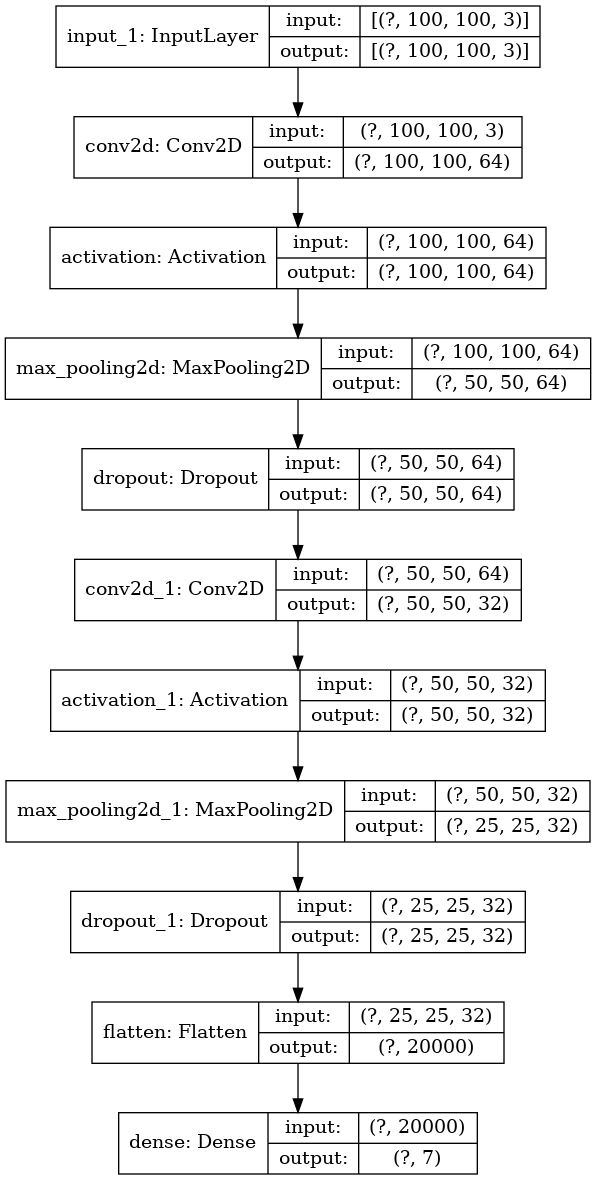

In [21]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
modelname = './models/' + model1.name + '_' + current_time
keras.utils.plot_model(model1, to_file = modelname + '.png', show_shapes = True)

## 4.3 Entrenamiento

### 4.2.2 Parámetros de transformación de imágenes (data augmentation)

In [22]:
rotation_range = 180     # rotación aleatoria en grados entre 0 a rotation_range
zoom_range = 0.1         # zoom aleatorio
width_shift_range = 0.1  # desplazamiento horizontal aleatorio (fracción del total)
height_shift_range = 0.1 # desplazamiento vertical aleatorio (fracción del total)
horizontal_flip = True   # transposición horizontal
vertical_flip = True     # transposición horizontal

In [23]:
batch_size = 60
epochs = 50
#defino un nuevo valor de steps_per_epoch así trabajo solo con batch_size
steps_per_epoch = train_X.shape[0] // batch_size
#steps_per_epoch = 30
patience = 10

In [24]:
earlystopper = EarlyStopping(monitor='val_loss', 
                             patience=patience, verbose=1,restore_best_weights=True)
callbacks = [earlystopper]

In [25]:
steps_per_epoch

38

In [26]:
train_X.shape

(2338, 100, 100, 3)

In [27]:
filepath = './checkpoints/' + model1.name + '_' + current_time + '_{epoch:02d}_{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor="val_loss", verbose=1, save_best_only=True)
callbacks.append(checkpoint)

In [28]:
bestepoch = utils.BestEpochCallback()
callbacks.append(bestepoch)

In [29]:
callbacks

In [30]:
training1, model1 = utils.train(model1,
                                train_X, 
                                train_y, 
                                batch_size = batch_size,
                                epochs = epochs,
                                validation_data_X = val_X, 
                                validation_data_y = val_y,
                                steps_per_epoch = steps_per_epoch,
                                rotation_range = rotation_range,
                                zoom_range = zoom_range, 
                                width_shift_range = width_shift_range,
                                height_shift_range = height_shift_range,
                                horizontal_flip = horizontal_flip,  
                                vertical_flip = vertical_flip,
                                callbacks = callbacks,
                                class_weights = class_weights
                               )

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 1.7001 - macro: 0.2606
Epoch 00001: val_loss improved from inf to 1.36750, saving model to ./checkpoints/model1_20201129_135343_01_1.37.h5
38/38 [==============================] - 9s 242ms/step - loss: 1.7001 - macro: 0.2606 - val_loss: 1.3675 - val_macro: 0.2699
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 1.0988 - macro: 0.4379
Epoch 00002: val_loss improved from 1.36750 to 0.86040, saving model to ./checkpoints/model1_20201129_135343_02_0.86.h5
38/38 [==============================] - 9s 231ms/step - loss: 1.0988 - macro: 0.4379 - val_loss: 0.8604 - val_macro: 0.4497
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.8013 - macro: 0.5450
Epoch 00003: val_loss did not improve from 0.86040
38/38 [==============================] - 9s 229ms/step - loss: 0.8013 - macro: 0.5450 - val_loss: 1.0109 - val_macro: 0.5463
Epoch 4/50
38/38 [==============================] - ETA: 0s - los

Epoch 29/50
38/38 [==============================] - ETA: 0s - loss: 0.1704 - macro: 0.8621
Epoch 00029: val_loss did not improve from 0.35601
38/38 [==============================] - 9s 227ms/step - loss: 0.1704 - macro: 0.8621 - val_loss: 0.4865 - val_macro: 0.8623
Epoch 30/50
38/38 [==============================] - ETA: 0s - loss: 0.1778 - macro: 0.8647
Epoch 00030: val_loss did not improve from 0.35601
38/38 [==============================] - 9s 226ms/step - loss: 0.1778 - macro: 0.8647 - val_loss: 0.4679 - val_macro: 0.8648
Epoch 31/50
38/38 [==============================] - ETA: 0s - loss: 0.1647 - macro: 0.8672
Epoch 00031: val_loss improved from 0.35601 to 0.32887, saving model to ./checkpoints/model1_20201129_135343_31_0.33.h5
38/38 [==============================] - 9s 230ms/step - loss: 0.1647 - macro: 0.8672 - val_loss: 0.3289 - val_macro: 0.8673
Epoch 32/50
38/38 [==============================] - ETA: 0s - loss: 0.1707 - macro: 0.8695
Epoch 00032: val_loss did not impro

## 4.3 Evaluación del modelo

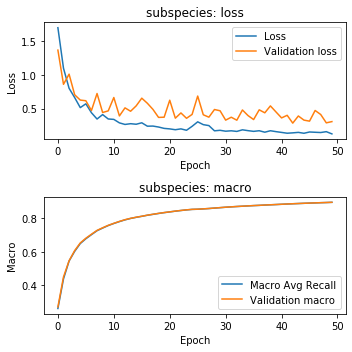

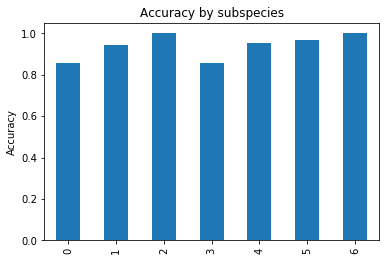

Classification report
                       precision    recall  f1-score   support

                   -1       0.86      0.87      0.87        70
1 Mixed local stock 2       0.54      0.94      0.68        69
  Carniolan honey bee       0.96      1.00      0.98        92
    Italian honey bee       0.98      0.86      0.92       490
    Russian honey bee       0.97      0.95      0.96       110
VSH Italian honey bee       0.88      0.97      0.92        29
    Western honey bee       1.00      1.00      1.00         7

             accuracy                           0.90       867
            macro avg       0.88      0.94      0.90       867
         weighted avg       0.93      0.90      0.91       867

Loss function: 0.23732790350914001


In [31]:
utils.eval_model(training1, model1, test_X, test_y, 'subspecies')

In [32]:
trainedmodelname = modelname + '_{:02d}_{:.2f}.h5'.format(bestepoch.best_epoch, bestepoch.best_loss)
model1.save(trainedmodelname)

In [33]:
saved_model = keras.models.load_model(trainedmodelname, 
                                      custom_objects = {'MacroAverageRecallMetric' : utils.MacroAverageRecallMetric})

In [34]:
df_subspecies = utils.load_test_and_generate_prediction_file(model1, img_width, img_height, img_channels, 'subspecies')
df_subspecies

,id,expected
0,0,-1
1,1,Italian honey bee
2,2,1 Mixed local stock 2
3,3,Italian honey bee
4,4,Italian honey bee
...,...,...
1702,1702,Italian honey bee
1703,1703,Italian honey bee
1704,1704,Italian honey bee
1705,1705,Carniolan honey bee
